## 발주 물동량과 회수 물동량 간의 관계를 파악합니다. 해당 분석에서는 발주와 회수 간의 주기성이 존재한다는 가정을 시험해 보았습니다.

In [1]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine


In [2]:
from _element import feature_control as ft_c
from _element.data_control import Data, DataRestruction, DataAddition
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve
from statsmodels.tsa.stattools import ccf, pacf
from sklearn.mixture import GaussianMixture

In [4]:
df_in= ft_c.xlsx_opener('KPP일별입고(13_17)_daily_obj.xlsx')
df_return= ft_c.xlsx_opener('KPP일별회수(13_17)_daily_obj.xlsx')

In [5]:
df_return.head()

,ds,1025,1032,1041,1057,1064,1091,1101,1117,1119,...,1797,1800,1815,1817,1818,1852,1853,1878,1891,y_sum
0,2013-01-01,0,0,81,0,0,0,0,0,0,...,0,0,7681,0,0,0,0,0,0,8374
1,2013-01-02,0,0,326,0,0,1,0,0,0,...,1,0,20876,0,0,0,100,181,0,26423
2,2013-01-03,0,0,312,0,0,0,0,0,0,...,1,0,22693,0,0,0,259,241,0,28156
3,2013-01-04,0,0,586,0,0,2,0,0,0,...,94,0,22571,0,0,0,252,455,2,29636
4,2013-01-05,0,0,218,0,0,0,0,0,0,...,0,0,21062,0,0,0,1150,211,2,27707


In [6]:
data= Data()
data.setRawData(df_return, dataname= 'return')
data.addData(df_in, dataname= 'in')

          ds  1025  1032  1041  1057  1064  1091  1101  1117  1119  ...    \
0 2013-01-01     0     0    81     0     0     0     0     0     0  ...     
1 2013-01-02     0     0   326     0     0     1     0     0     0  ...     
2 2013-01-03     0     0   312     0     0     0     0     0     0  ...     
3 2013-01-04     0     0   586     0     0     2     0     0     0  ...     
4 2013-01-05     0     0   218     0     0     0     0     0     0  ...     

   1797  1800   1815  1817  1818  1852  1853  1878  1891  y_sum  
0     0     0   7681     0     0     0     0     0     0   8374  
1     1     0  20876     0     0     0   100   181     0  26423  
2     1     0  22693     0     0     0   259   241     0  28156  
3    94     0  22571     0     0     0   252   455     2  29636  
4     0     0  21062     0     0     0  1150   211     2  27707  

[5 rows x 40 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 40 columns):
ds       17

In [7]:
restruct= DataRestruction(data)
restruct.addRegion(7, 'weekday', start_num= 1)
restruct.commitRestructedData()

          ds  1025  1032  1041  1057  1064  1091  1101  1117  1119   ...     \
0 2013-01-01     0     0    81     0     0     0     0     0     0   ...      
1 2013-01-02     0     0   326     0     0     1     0     0     0   ...      
2 2013-01-03     0     0   312     0     0     0     0     0     0   ...      
3 2013-01-04     0     0   586     0     0     2     0     0     0   ...      
4 2013-01-05     0     0   218     0     0     0     0     0     0   ...      

   1800   1815  1817  1818  1852  1853  1878  1891  y_sum  weekday  
0     0   7681     0     0     0     0     0     0   8374        1  
1     0  20876     0     0     0   100   181     0  26423        2  
2     0  22693     0     0     0   259   241     0  28156        3  
3     0  22571     0     0     0   252   455     2  29636        4  
4     0  21062     0     0     0  1150   211     2  27707        5  

[5 rows x 41 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (

* 편의를 위해 주말 데이터를 제외하였고, 최근 3년의 데이터를 활용하였습니다.

In [24]:
df_ds= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5].ds[-761:]
df_in_1692= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5][1692][-761:]
df_return_1692= data.data[frozenset({'return'})][data.data[frozenset({'return'})].weekday < 5][1692][-761:]

* plot 그래프입니다.

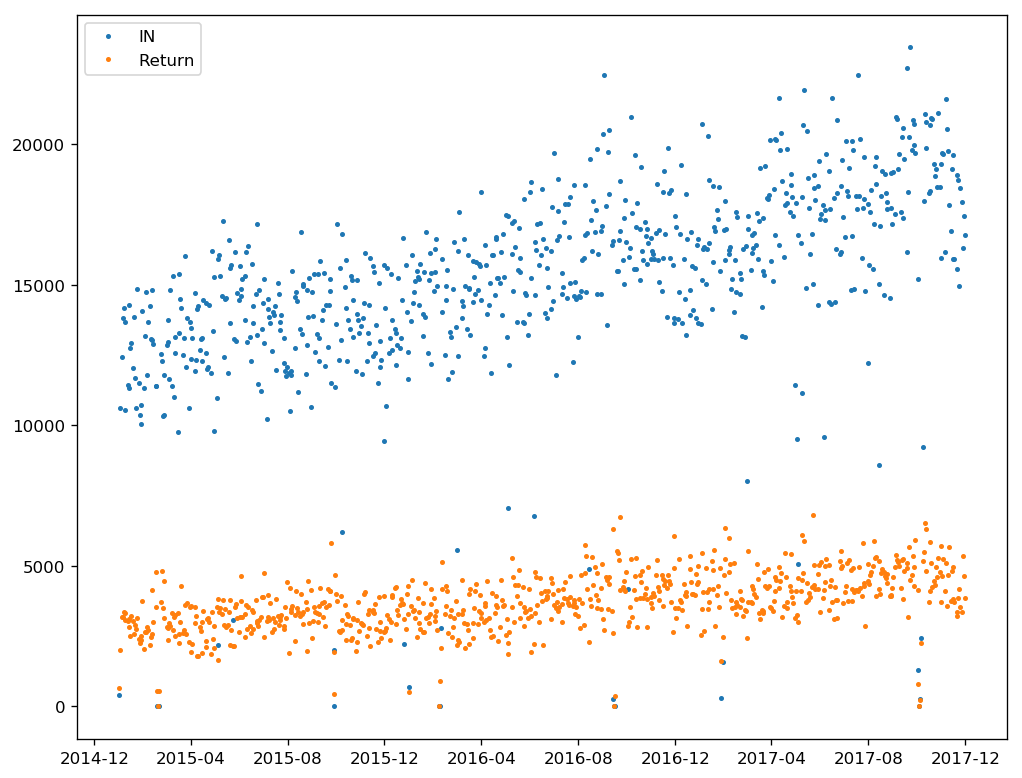

In [27]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds, df_in_1692, label= 'IN', ms= 2)
plt.plot_date(df_ds, df_return_1692, label= 'Return', ms= 2)
plt.legend()
plt.show()

* Convolve 그래프를 그렸습니다. Convolve는 발주 물동량과 n일 전의 회수 물동량 간의 상호 관계를 n에 따라 나타낸 그래프입니다.

여기서 그래프가 0을 중심으로 직각삼각형에 가까운 모형을 보이고 있습니다. 이는 특정한 n일 이전의 데이터가 미치는 영향이 크지 않음을 나타냅니다.

In [28]:
convolve= fftconvolve(df_in_1692, df_return_1692)
convolve.size

1521

In [30]:
np.arange(-760, 761).size

1521

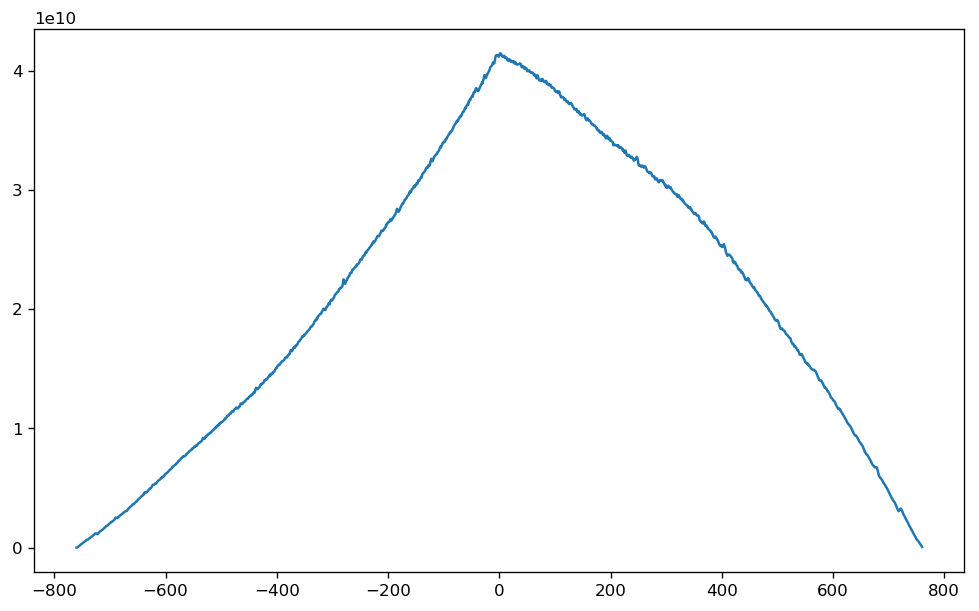

In [31]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, convolve)
plt.show()

In [32]:
corr= np.correlate(df_in_1692, df_return_1692, 'full')
corr.size

1521

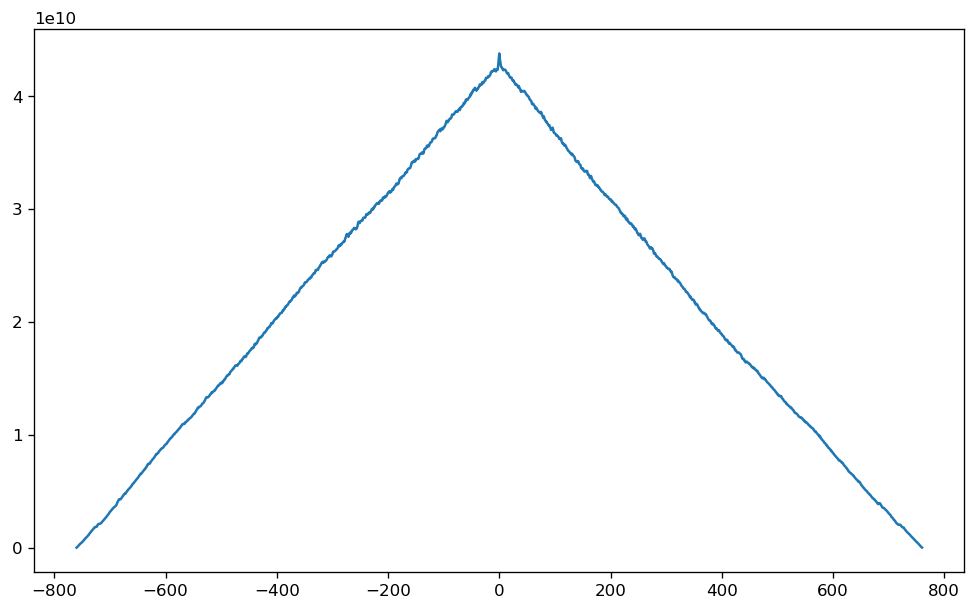

In [33]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, corr)
plt.show()

In [34]:
corr.max()

43801250473

In [35]:
np.where(corr== corr.max())

(array([760], dtype=int64),)

* 발주 물동량과 회수 물동량 간의 cross-correlation을 그래프로 나타냈습니다. 많은 경우 아래와 같이 우하향하는 그래프가 형성되며, 그래프에 따라 특정하게 높은 상관관계를 보이는 일자가 나타납니다.

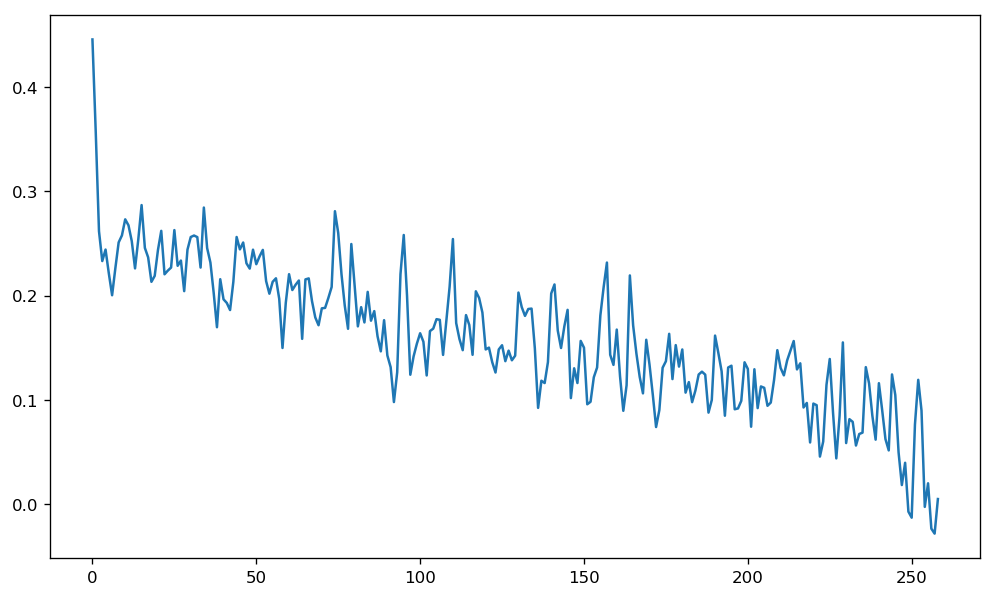

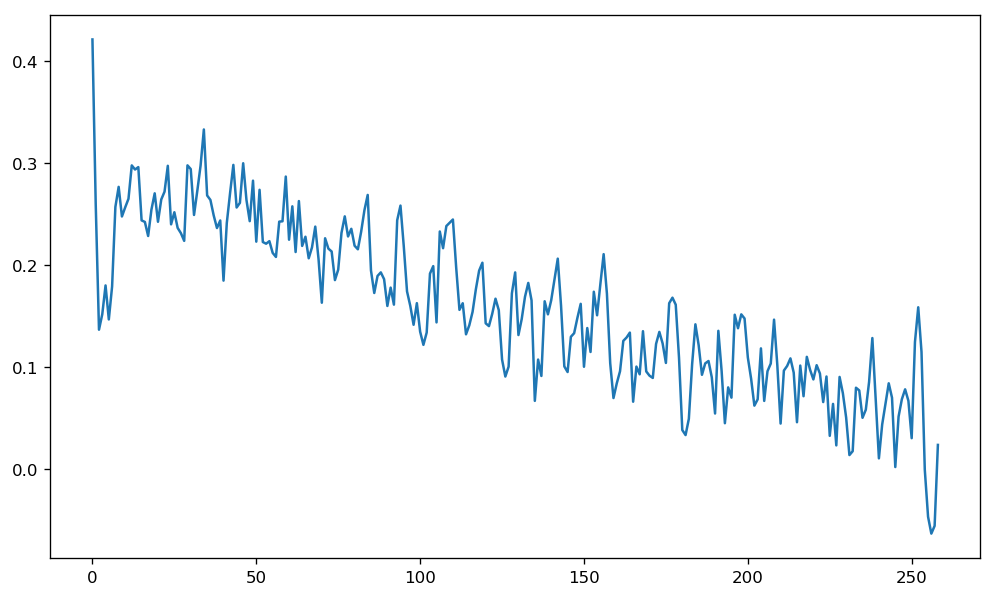

In [40]:
crosscorr= ccf(df_in_1692, df_return_1692, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()
crosscorr= ccf(df_return_1692, df_in_1692, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()

* cross-correlation을 크기 순서대로 나열한 dataframe입니다.

In [41]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
511,-0.413308
498,-0.411038
447,-0.401651
485,-0.399997
513,-0.393008
442,-0.377572
456,-0.372647
443,-0.368701
512,-0.365561
493,-0.365191


* 1692 유형의 auto-correlation을 분석하였습니다.

lag 0: corr 1.0
lag 1: corr 0.5052830905424801
lag 2: corr 0.39805742766944086
lag 95: corr 0.3156247393581667
lag 253: corr 0.31154131458128737
lag 275: corr 0.30349198342175254
lag 96: corr 0.29500360806213766
lag 157: corr 0.2948342913307634
lag 158: corr 0.29088605736915624
lag 110: corr 0.28638903234002994
lag 35: corr 0.27911170342890373
lag 252: corr 0.27486177884669677
lag 111: corr 0.2656348225605484
lag 47: corr 0.26055955234408773
lag 45: corr 0.2593621352953631
lag 156: corr 0.2586294676478865
lag 97: corr 0.2583524623358234
lag 69: corr 0.2510819500643944
lag 50: corr 0.25053151041505023
lag 40: corr 0.24544745651009767
lag 46: corr 0.24539206281002182
lag 3: corr 0.2433470161154313
lag 261: corr 0.24214189489469842
lag 254: corr 0.24212055929195775
lag 60: corr 0.2418696075848295
lag 70: corr 0.24185652319875137
lag 155: corr 0.2376963409742789
lag 274: corr 0.2372482860384806
lag 43: corr 0.2371841275253121
lag 15: corr 0.2365171737919829
lag 30: corr 0.2364364287661181


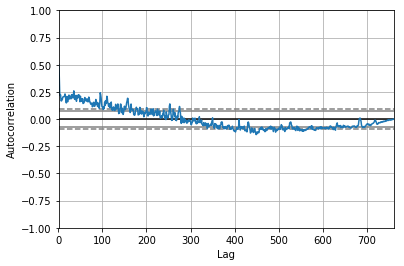

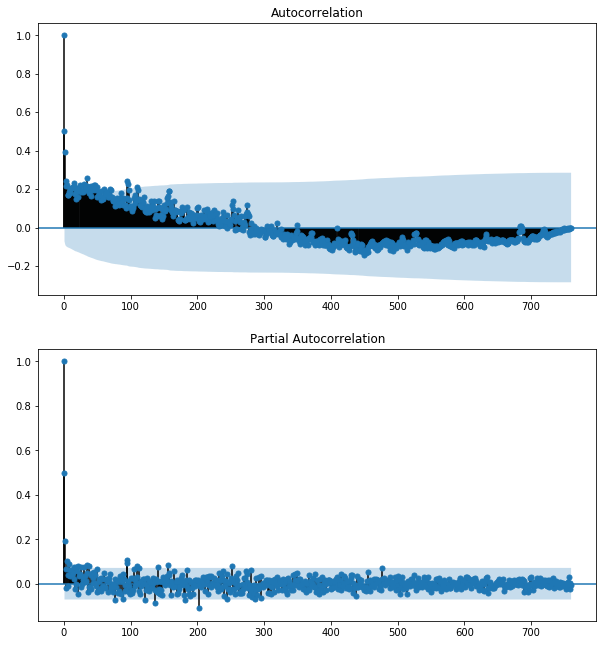

In [43]:
Arima_timeseries().corr_check(df_in_1692)
Arima_timeseries().acf_plot(df_in_1692)

lag 0: corr 0.9999999999999999
lag 1: corr 0.4442150415683678
lag 35: corr 0.3652575186801582
lag 45: corr 0.3574534945349556
lag 75: corr 0.35065421053290025
lag 30: corr 0.3487079181372569
lag 10: corr 0.3387721585790978
lag 36: corr 0.33445583810708873
lag 49: corr 0.3299969028007871
lag 65: corr 0.32874412716016727
lag 12: corr 0.32436413359324706
lag 13: corr 0.319797818145033
lag 50: corr 0.3196871705290082
lag 22: corr 0.31905000949141965
lag 60: corr 0.31827800293077213
lag 9: corr 0.3178788169102391
lag 31: corr 0.31691471863600923
lag 25: corr 0.31417614164788227
lag 64: corr 0.3137639841548512
lag 15: corr 0.31030888122763917
lag 34: corr 0.3099937833457617
lag 61: corr 0.3099195411072223
lag 26: corr 0.30949127909423324
lag 23: corr 0.3084214289499327
lag 14: corr 0.3069669751906098
lag 130: corr 0.3056475559066154
lag 68: corr 0.3030737381285284
lag 66: corr 0.30106118868064785
lag 24: corr 0.29797804414351986
lag 80: corr 0.2977091578273542
lag 84: corr 0.2972872171163523

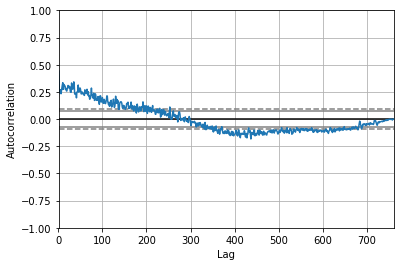

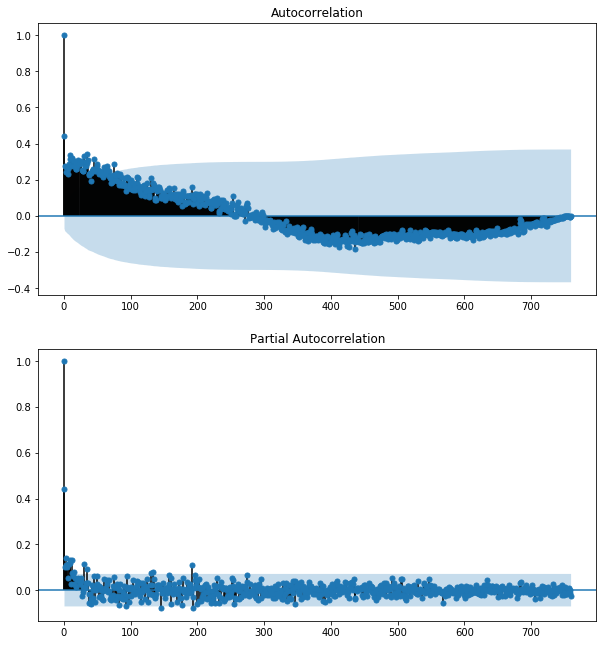

In [44]:
Arima_timeseries().corr_check(df_return_1692)
Arima_timeseries().acf_plot(df_return_1692)

* 1692 유형 물동량의 1일 차분 데이터를 유사한 방식으로 분석하였습니다.

이 경우 특히 이전에 나타났던 연관성이 사라지는 것으로 나타났습니다.

In [45]:
df_return_diff1= df_return_1692.diff(1).iloc[1:]
df_in_diff1= df_in_1692.diff(1).iloc[1:]

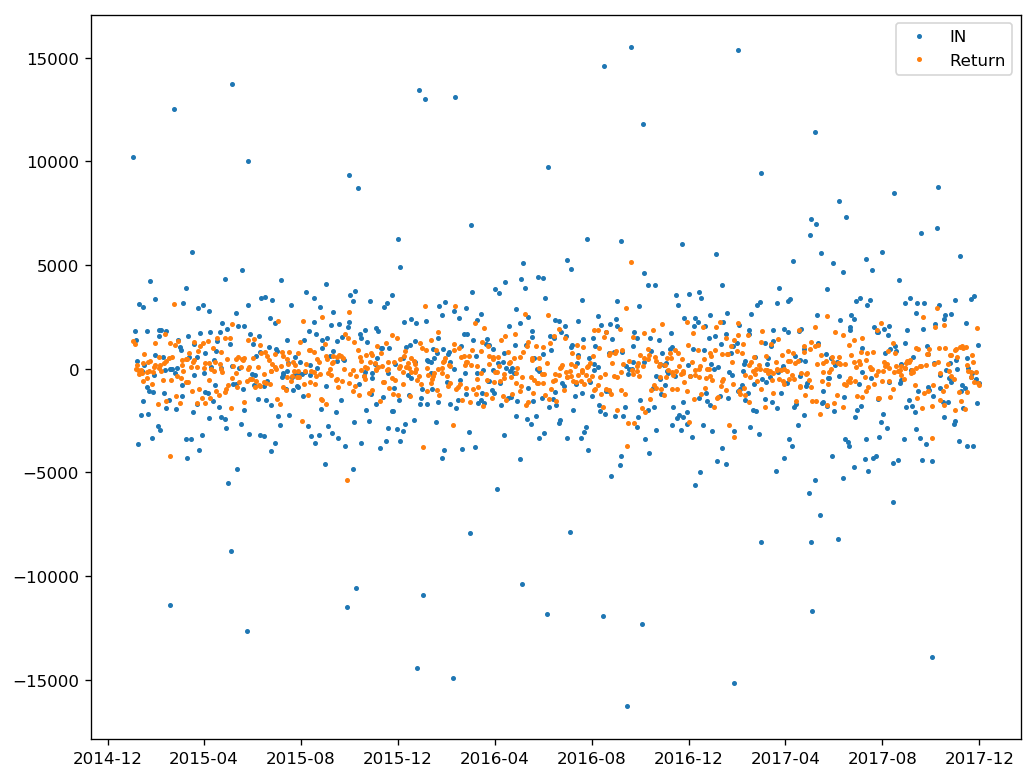

In [46]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds.iloc[1:], df_in_diff1, label= 'IN', ms= 2)
plt.plot_date(df_ds.iloc[1:], df_return_diff1, label= 'Return', ms= 2)
plt.legend()
plt.show()

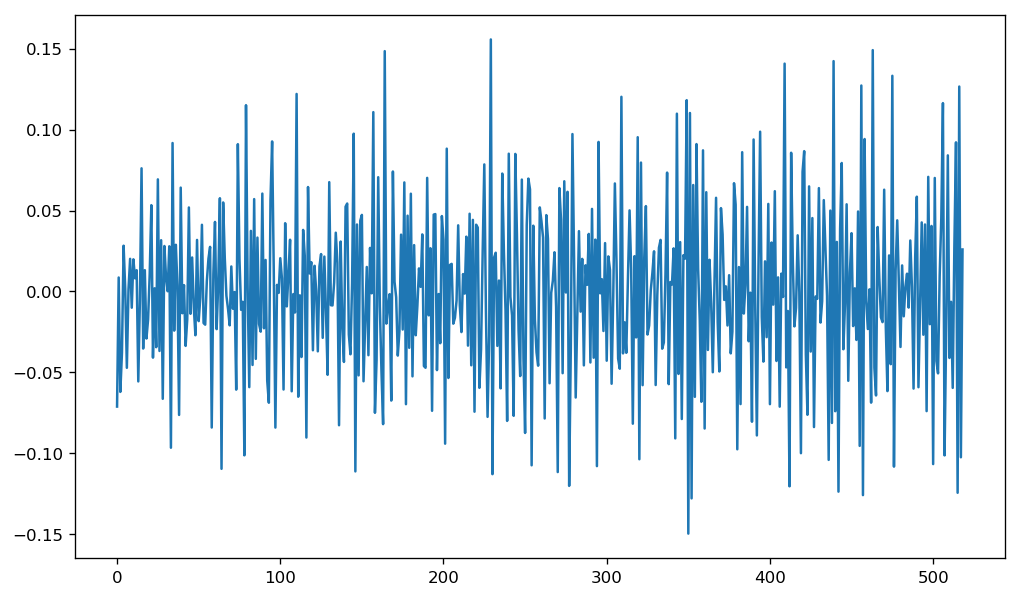

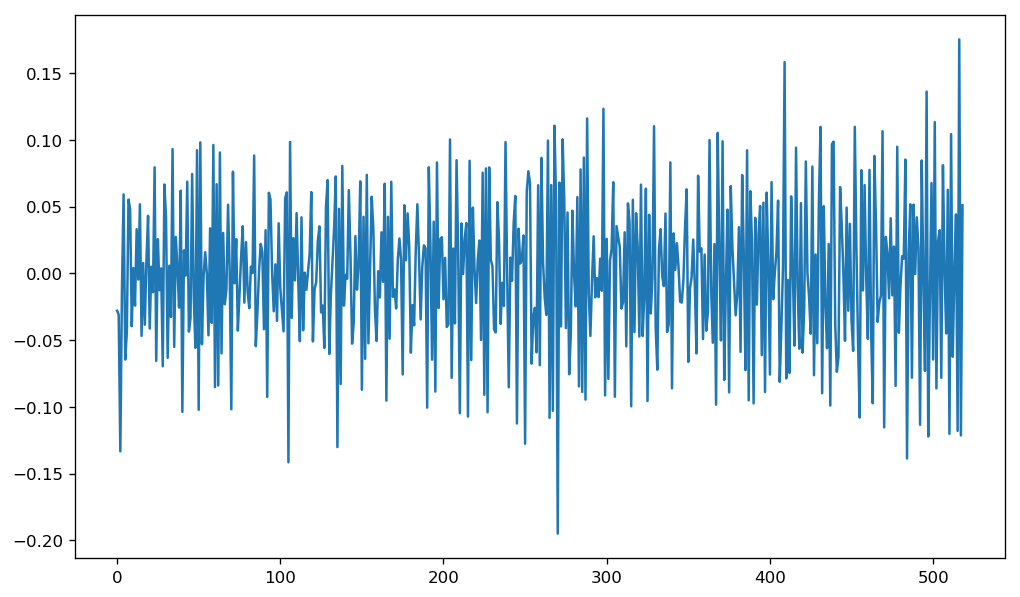

In [47]:
crosscorr= ccf(df_in_diff1, df_return_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()
crosscorr= ccf(df_return_diff1, df_in_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()

In [48]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
271,-0.194901
106,-0.141485
485,-0.138657
3,-0.133299
136,-0.130110
251,-0.127601
498,-0.122180
518,-0.121347
511,-0.120153
516,-0.117963


#### 1041 유형에 대해 동일한 분석을 진행하였습니다.

In [49]:
df_ds= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5].ds[-761:]
df_in_1041= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5][1041][-761:]
df_return_1041= data.data[frozenset({'return'})][data.data[frozenset({'return'})].weekday < 5][1041][-761:]

In [50]:
df_ds

730    2015-01-01
731    2015-01-02
734    2015-01-05
735    2015-01-06
736    2015-01-07
737    2015-01-08
738    2015-01-09
741    2015-01-12
742    2015-01-13
743    2015-01-14
744    2015-01-15
745    2015-01-16
748    2015-01-19
749    2015-01-20
750    2015-01-21
751    2015-01-22
752    2015-01-23
755    2015-01-26
756    2015-01-27
757    2015-01-28
758    2015-01-29
759    2015-01-30
762    2015-02-02
763    2015-02-03
764    2015-02-04
765    2015-02-05
766    2015-02-06
769    2015-02-09
770    2015-02-10
771    2015-02-11
          ...    
1753   2017-10-20
1756   2017-10-23
1757   2017-10-24
1758   2017-10-25
1759   2017-10-26
1760   2017-10-27
1763   2017-10-30
1764   2017-10-31
1765   2017-11-01
1766   2017-11-02
1767   2017-11-03
1770   2017-11-06
1771   2017-11-07
1772   2017-11-08
1773   2017-11-09
1774   2017-11-10
1777   2017-11-13
1778   2017-11-14
1779   2017-11-15
1780   2017-11-16
1781   2017-11-17
1784   2017-11-20
1785   2017-11-21
1786   2017-11-22
1787   201

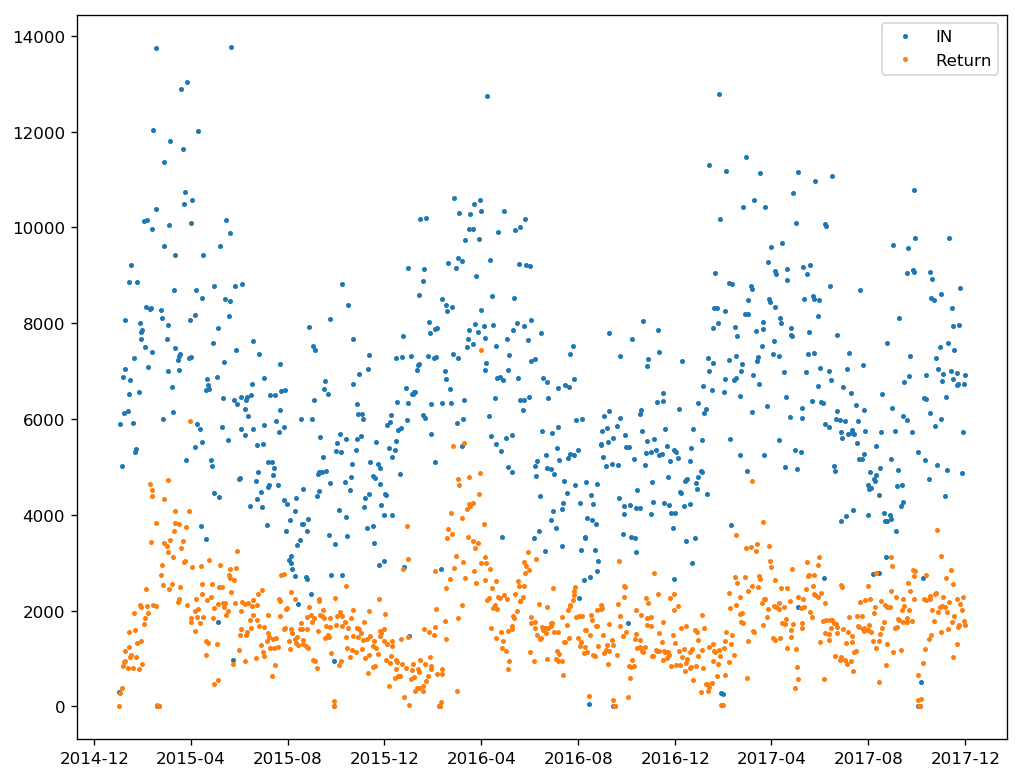

In [51]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds, df_in_1041, label= 'IN', ms= 2)
plt.plot_date(df_ds, df_return_1041, label= 'Return', ms= 2)
plt.legend()
plt.show()

In [52]:
convolve= fftconvolve(df_in_1041, df_return_1041)
convolve.size

1521

In [53]:
np.arange(-760, 761).size

1521

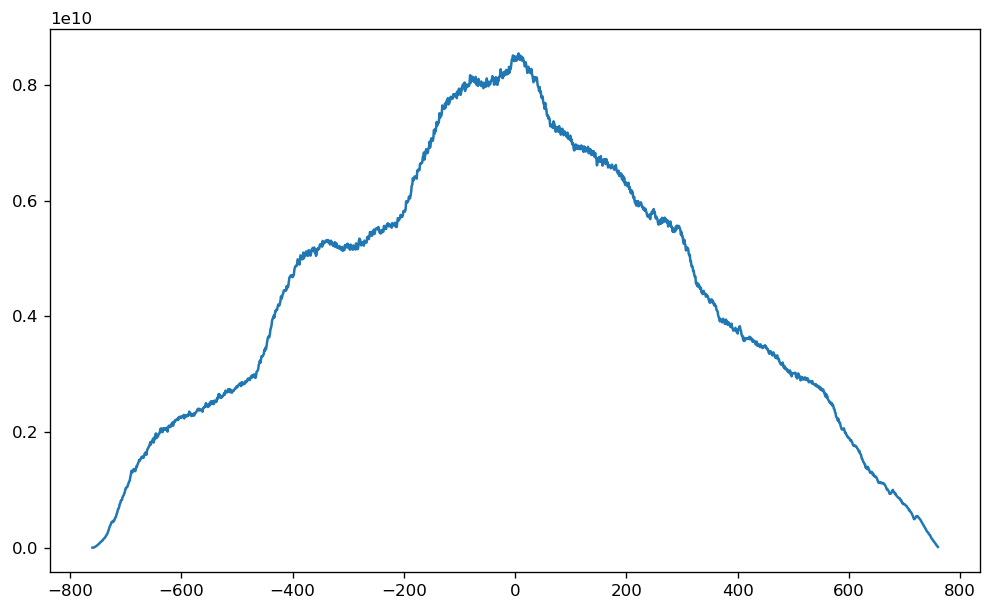

In [54]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, convolve)
plt.show()

In [55]:
corr= np.correlate(df_in_1041, df_return_1041, 'full')
corr.size

1521

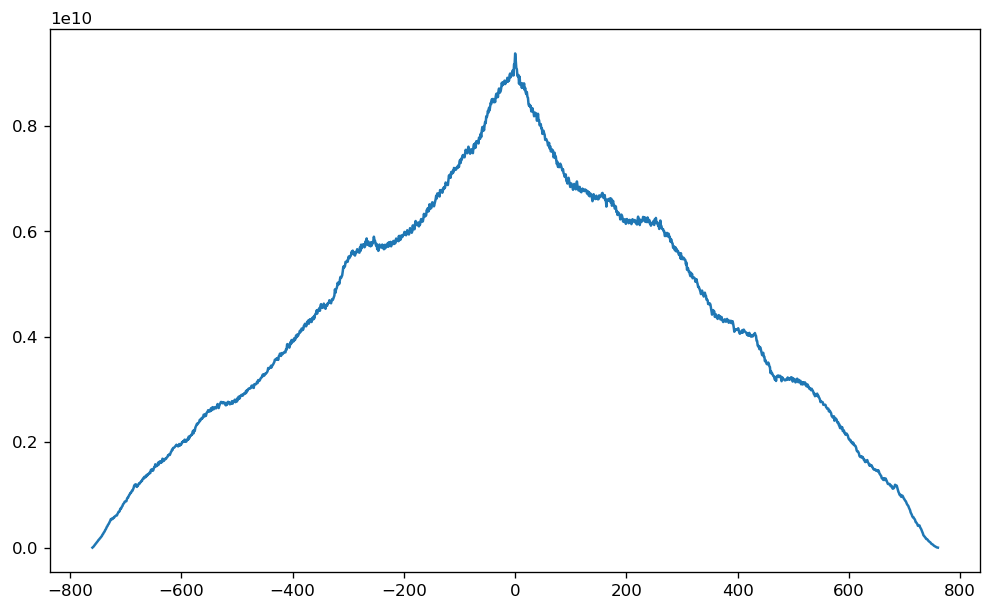

In [56]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, corr)
plt.show()

In [57]:
corr.max()

9371648069

In [58]:
np.where(corr== corr.max())

(array([760], dtype=int64),)

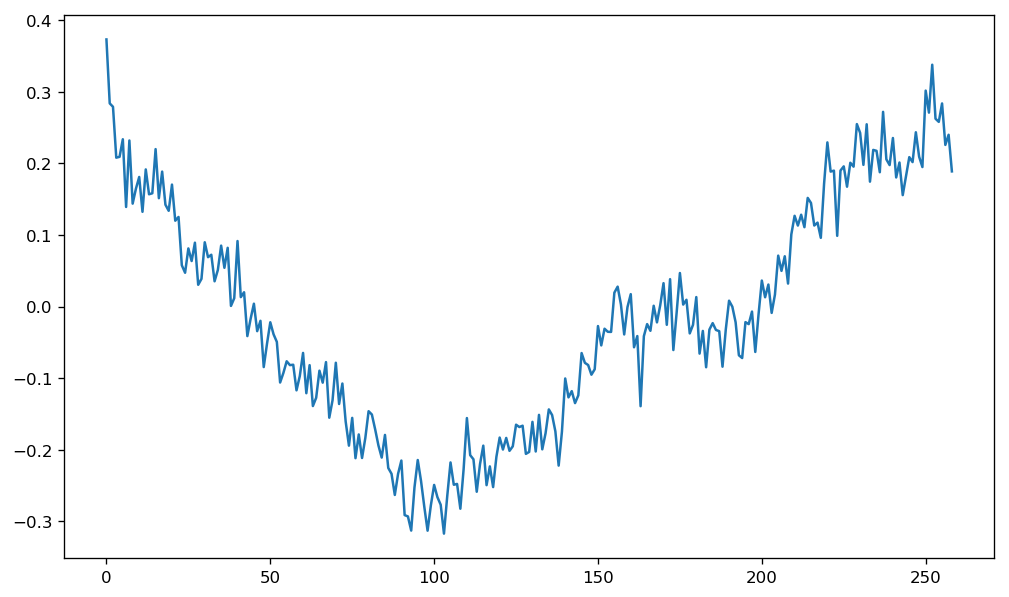

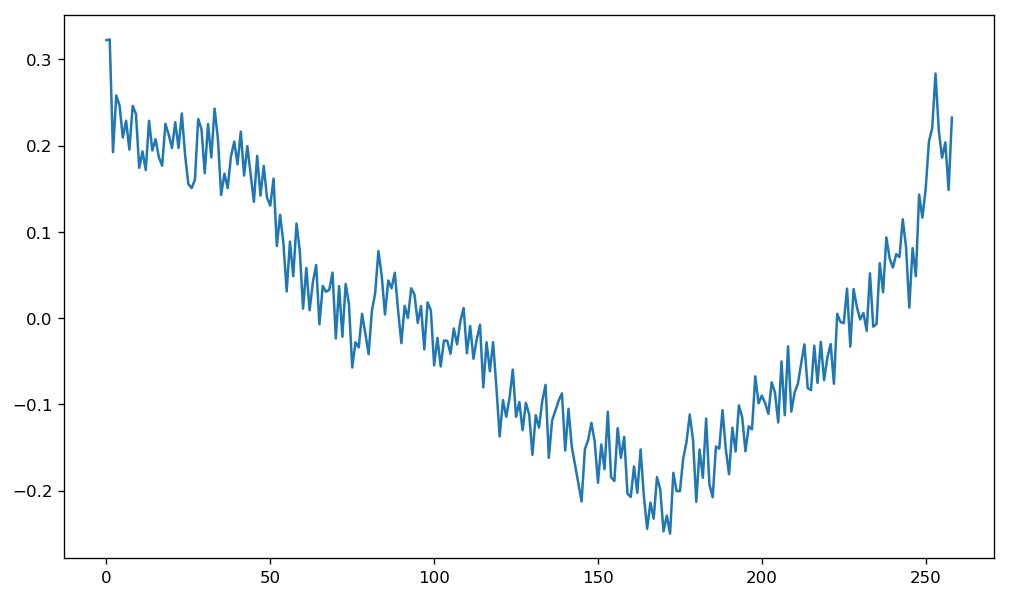

In [59]:
crosscorr= ccf(df_in_1041, df_return_1041, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()
crosscorr= ccf(df_return_1041, df_in_1041, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()

In [60]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
173,-0.249988
171,-0.247333
166,-0.244415
168,-0.232631
172,-0.229054
167,-0.214062
181,-0.213095
146,-0.212697
186,-0.207839
161,-0.207488


lag 0: corr 1.0
lag 1: corr 0.44199576064267476
lag 275: corr 0.4018122954420026
lag 260: corr 0.3964352710200319
lag 261: corr 0.39593354647610834
lag 2: corr 0.3825547662844078
lag 5: corr 0.37800374164008554
lag 265: corr 0.3740134235911994
lag 255: corr 0.37107917034995586
lag 270: corr 0.3528415553614159
lag 262: corr 0.33920284988687727
lag 254: corr 0.33629666699081084
lag 10: corr 0.32314634304168766
lag 15: corr 0.3222323304264874
lag 253: corr 0.32082513911560684
lag 290: corr 0.31837209805282923
lag 280: corr 0.305354978690112
lag 266: corr 0.3050375785467525
lag 274: corr 0.3041726936704297
lag 263: corr 0.2946355462495003
lag 285: corr 0.29340099634585276
lag 259: corr 0.2922700772277136
lag 264: corr 0.2906889567976588
lag 295: corr 0.28732921843818854
lag 245: corr 0.286514827780158
lag 20: corr 0.2862593303699665
lag 267: corr 0.28456761958795185
lag 272: corr 0.2842778946270817
lag 8: corr 0.2827347920351367
lag 300: corr 0.28176616595733855
lag 3: corr 0.2740581145720

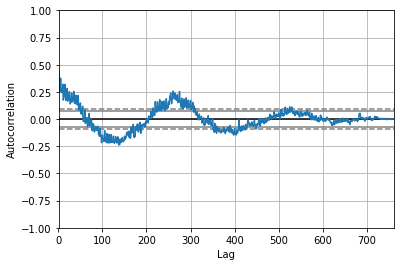

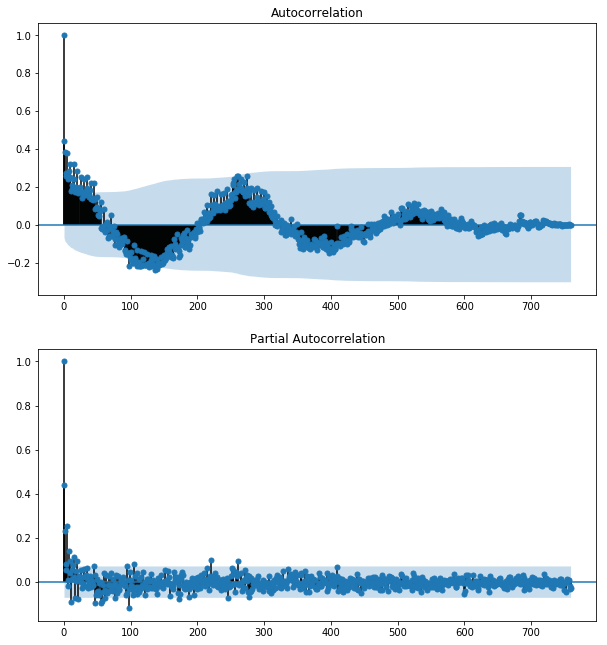

In [61]:
Arima_timeseries().corr_check(df_in_1041)
Arima_timeseries().acf_plot(df_in_1041)

lag 0: corr 0.9999999999999999
lag 1: corr 0.5769741052100957
lag 2: corr 0.504964870310347
lag 262: corr 0.44274980470313974
lag 3: corr 0.4337483965708406
lag 267: corr 0.40735964374993655
lag 4: corr 0.3986380082546604
lag 261: corr 0.39591195871272516
lag 268: corr 0.3898612130506933
lag 5: corr 0.38884152083432794
lag 10: corr 0.38675203353599424
lag 260: corr 0.38277880893158095
lag 265: corr 0.37884920063039407
lag 263: corr 0.37609260201221156
lag 259: corr 0.3715909534375975
lag 257: corr 0.3677520406730628
lag 255: corr 0.3656195519555105
lag 269: corr 0.3559509963680946
lag 272: corr 0.3512111881634512
lag 6: corr 0.3475714918514359
lag 270: corr 0.34584094493919887
lag 266: corr 0.3438136625233538
lag 254: corr 0.3348184841273393
lag 256: corr 0.3330498441590292
lag 264: corr 0.3287414400958529
lag 253: corr 0.3259615664021893
lag 273: corr 0.3248568874557012
lag 258: corr 0.3246836204894369
lag 8: corr 0.3233973909519713
lag 252: corr 0.31440488992536203
lag 13: corr 0.312

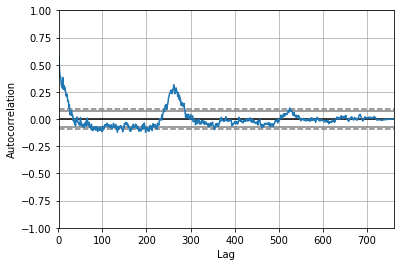

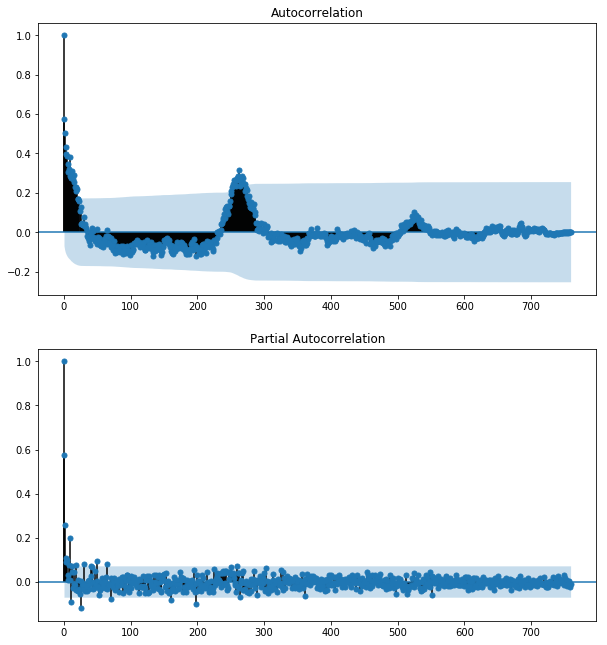

In [62]:
Arima_timeseries().corr_check(df_return_1041)
Arima_timeseries().acf_plot(df_return_1041)

In [63]:
df_return_diff1= df_return_1041.diff(1).iloc[1:]
df_in_diff1= df_in_1041.diff(1).iloc[1:]

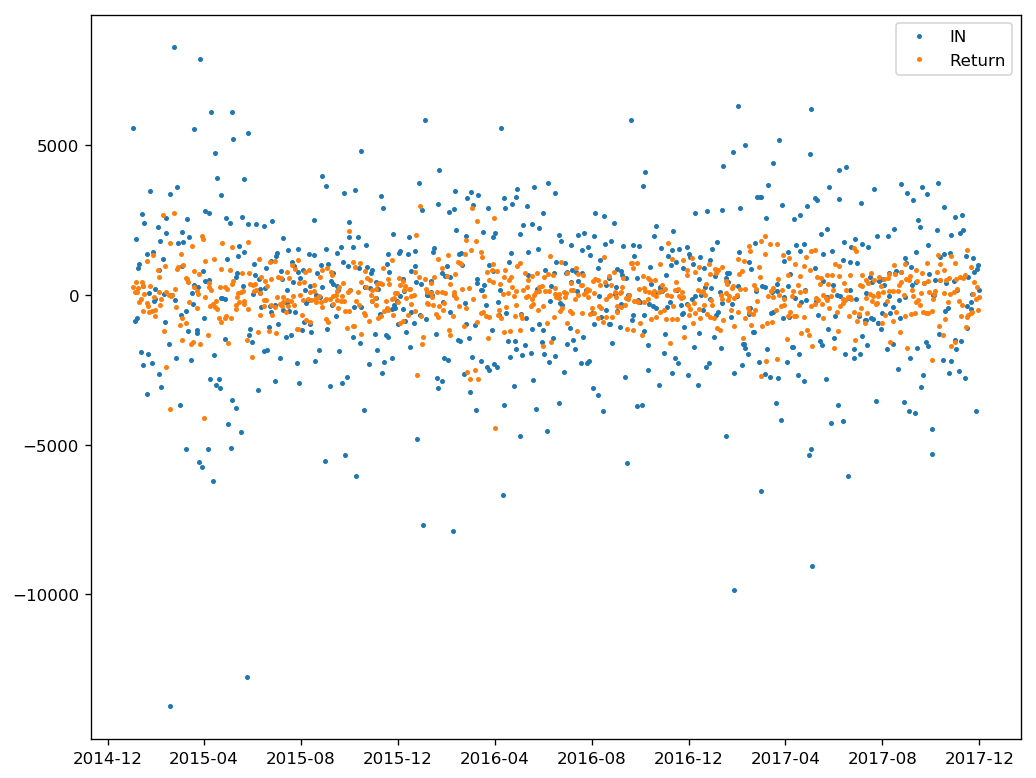

In [64]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds.iloc[1:], df_in_diff1, label= 'IN', ms= 2)
plt.plot_date(df_ds.iloc[1:], df_return_diff1, label= 'Return', ms= 2)
plt.legend()
plt.show()

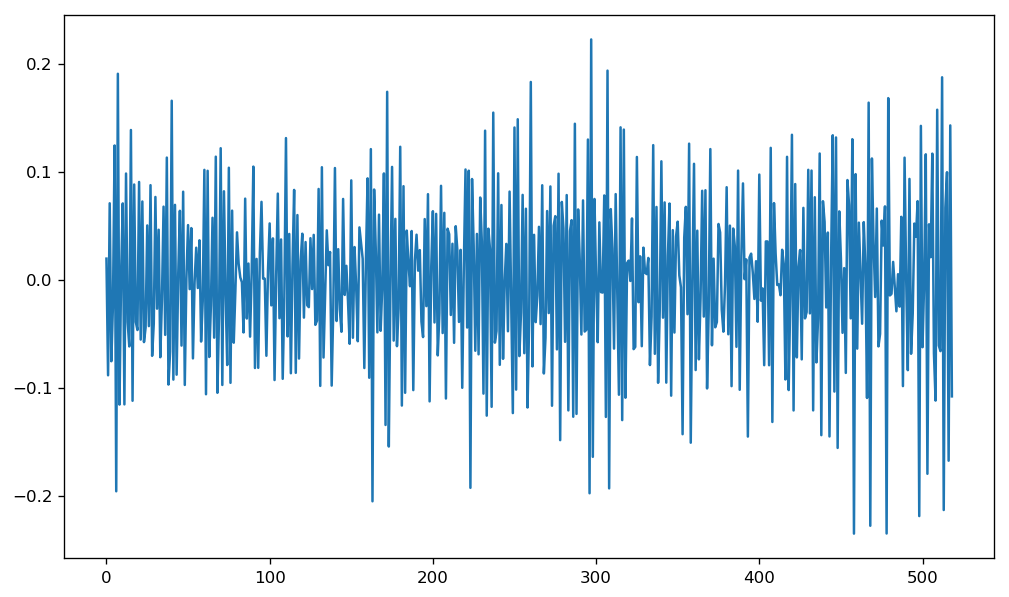

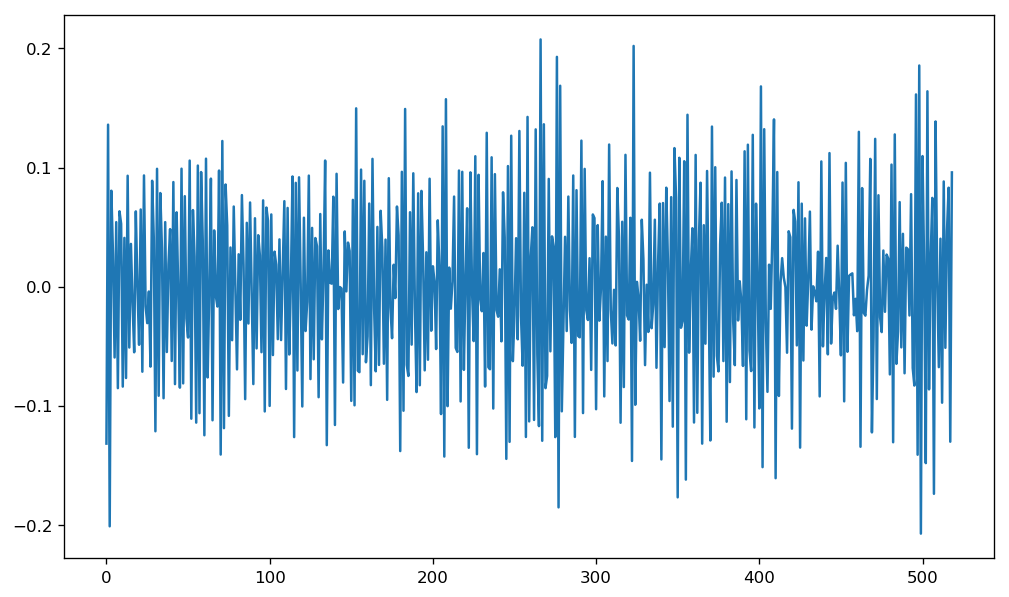

In [65]:
crosscorr= ccf(df_in_diff1, df_return_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()
crosscorr= ccf(df_return_diff1, df_in_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()

In [66]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
500,-0.207455
3,-0.201315
278,-0.185413
351,-0.176976
508,-0.174013
356,-0.162096
411,-0.160902
403,-0.151622
503,-0.148242
323,-0.146425


#### 1261 유형의 데이터에 대해 동일한 분석을 실시하였습니다.

In [67]:
df_ds= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5].ds[-761:]
df_in_1261= data.data[frozenset({'in'})][data.data[frozenset({'in'})].weekday < 5][1261][-761:]
df_return_1261= data.data[frozenset({'return'})][data.data[frozenset({'return'})].weekday < 5][1261][-761:]

In [68]:
df_ds

730    2015-01-01
731    2015-01-02
734    2015-01-05
735    2015-01-06
736    2015-01-07
737    2015-01-08
738    2015-01-09
741    2015-01-12
742    2015-01-13
743    2015-01-14
744    2015-01-15
745    2015-01-16
748    2015-01-19
749    2015-01-20
750    2015-01-21
751    2015-01-22
752    2015-01-23
755    2015-01-26
756    2015-01-27
757    2015-01-28
758    2015-01-29
759    2015-01-30
762    2015-02-02
763    2015-02-03
764    2015-02-04
765    2015-02-05
766    2015-02-06
769    2015-02-09
770    2015-02-10
771    2015-02-11
          ...    
1753   2017-10-20
1756   2017-10-23
1757   2017-10-24
1758   2017-10-25
1759   2017-10-26
1760   2017-10-27
1763   2017-10-30
1764   2017-10-31
1765   2017-11-01
1766   2017-11-02
1767   2017-11-03
1770   2017-11-06
1771   2017-11-07
1772   2017-11-08
1773   2017-11-09
1774   2017-11-10
1777   2017-11-13
1778   2017-11-14
1779   2017-11-15
1780   2017-11-16
1781   2017-11-17
1784   2017-11-20
1785   2017-11-21
1786   2017-11-22
1787   201

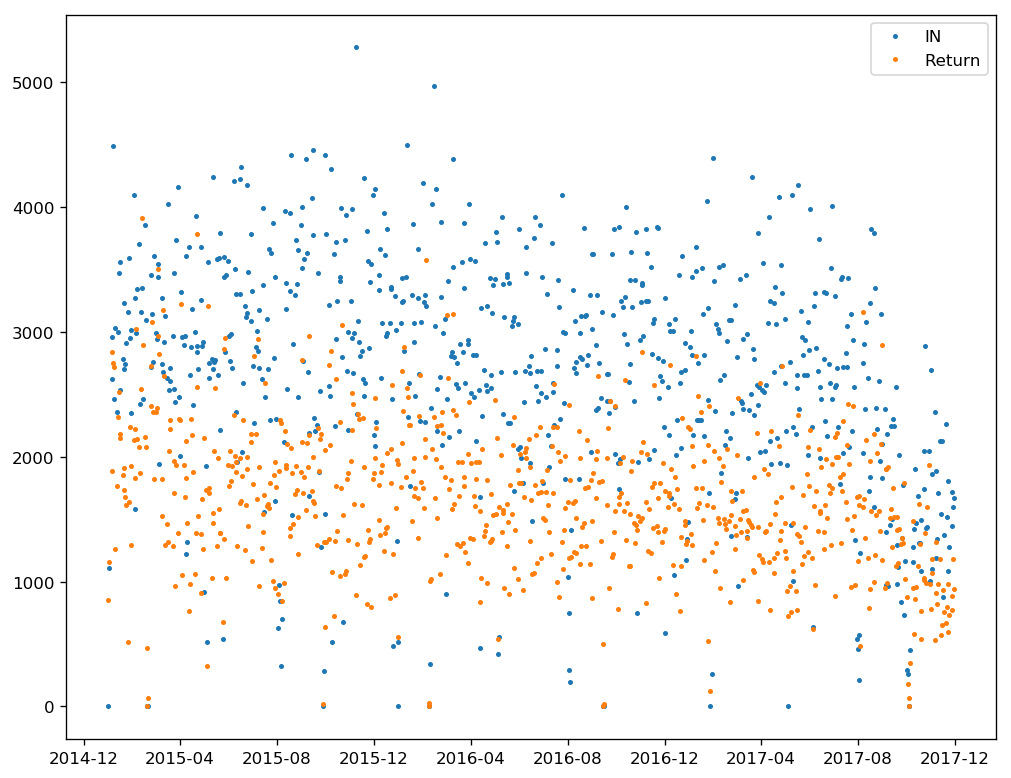

In [69]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds, df_in_1261, label= 'IN', ms= 2)
plt.plot_date(df_ds, df_return_1261, label= 'Return', ms= 2)
plt.legend()
plt.show()

In [70]:
convolve= fftconvolve(df_in_1261, df_return_1261)
convolve.size

1521

In [71]:
np.arange(-760, 761).size

1521

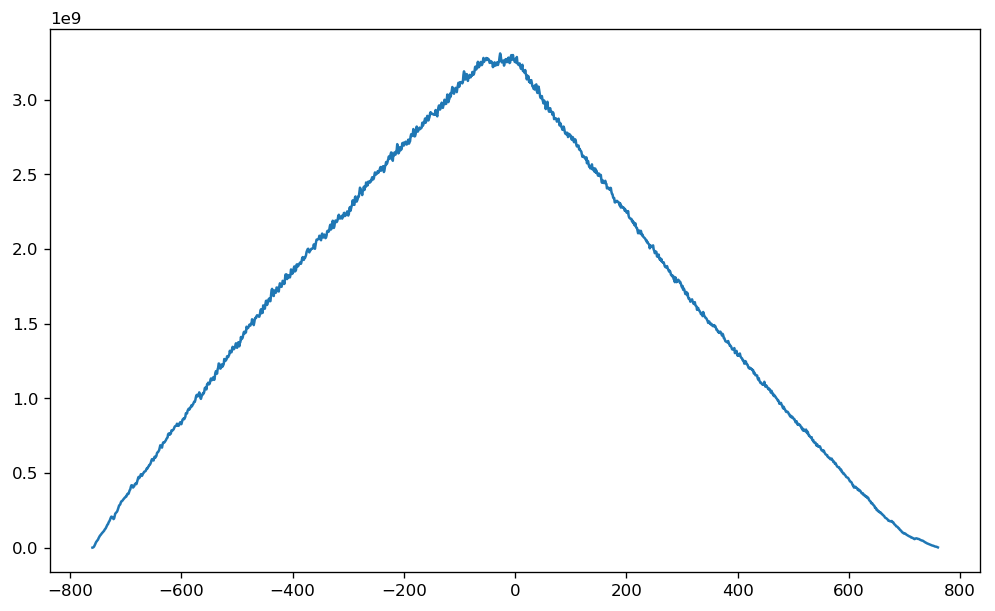

In [72]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, convolve)
plt.show()

In [73]:
corr= np.correlate(df_in_1261, df_return_1261, 'full')
corr.size

1521

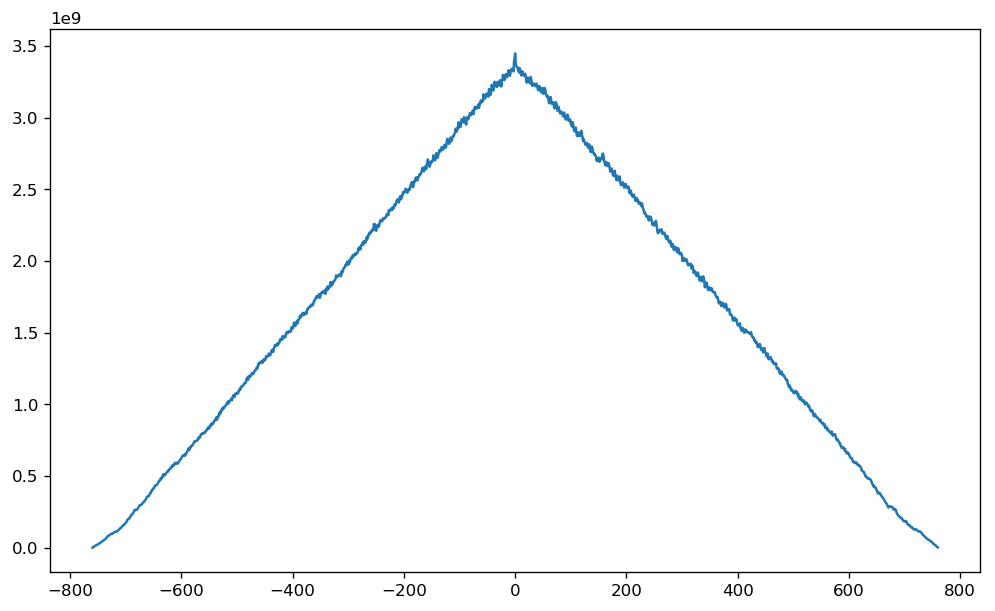

In [74]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-760, 761)
plt.plot(x_val, corr)
plt.show()

In [75]:
corr.max()

3449302164

In [76]:
np.where(corr== corr.max())

(array([760], dtype=int64),)

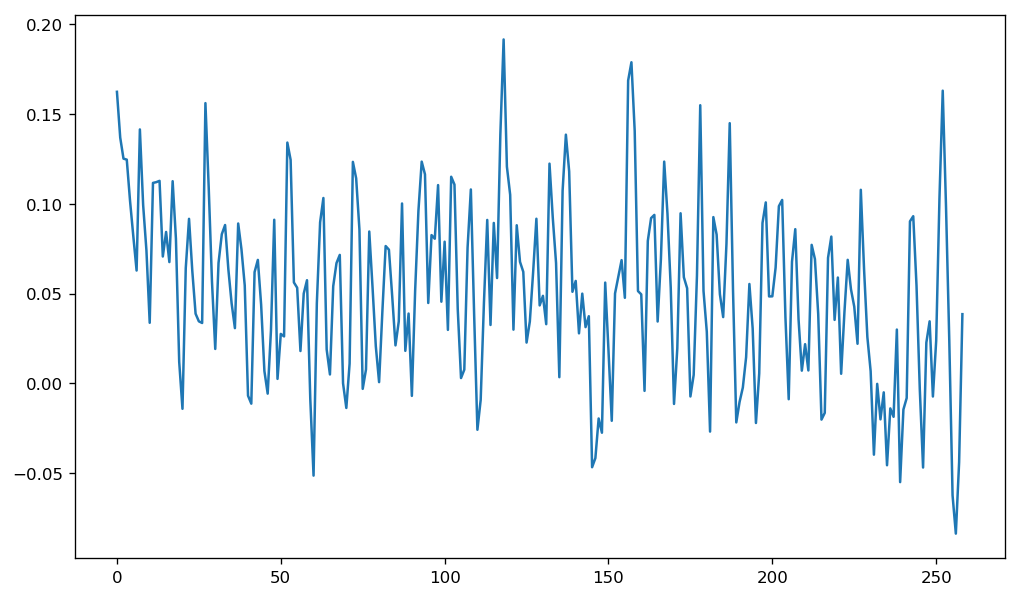

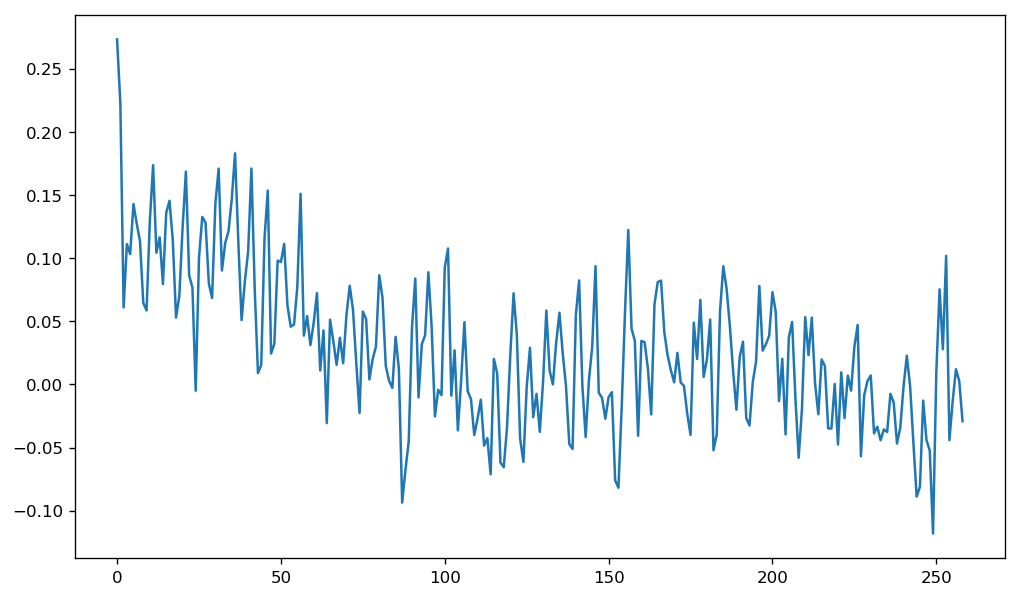

In [77]:
crosscorr= ccf(df_in_1261, df_return_1261, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()
crosscorr= ccf(df_return_1261, df_in_1261, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()

In [78]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
509,-0.250836
504,-0.236559
516,-0.207752
498,-0.202079
505,-0.187572
435,-0.171180
514,-0.165402
476,-0.164994
506,-0.163820
499,-0.161056


lag 0: corr 1.0
lag 1: corr 0.3680057002583399
lag 2: corr 0.24946256874865144
lag 45: corr 0.2319515037925136
lag 260: corr 0.18729746385376603
lag 5: corr 0.18429422789962532
lag 10: corr 0.17132565638123431
lag 35: corr 0.17116095231069792
lag 305: corr 0.16175498850461864
lag 3: corr 0.1552111460975043
lag 20: corr 0.15441032292737975
lag 50: corr 0.149577822351776
lag 4: corr 0.14380441144649725
lag 280: corr 0.14339707470280852
lag 34: corr 0.14279177764533213
lag 157: corr 0.13510076836101964
lag 158: corr 0.13509019158760285
lag 28: corr 0.13457586361711146
lag 259: corr 0.13419916582491317
lag 44: corr 0.13387927248411816
lag 310: corr 0.13086456734937466
lag 15: corr 0.1298947208891101
lag 300: corr 0.12867323454270746
lag 185: corr 0.12693145039018422
lag 252: corr 0.12678009373621488
lag 46: corr 0.12664526215964428
lag 105: corr 0.12661029594382214
lag 31: corr 0.1252416932439203
lag 30: corr 0.12380206746807251
lag 261: corr 0.1227319958773841
lag 29: corr 0.1217271215652

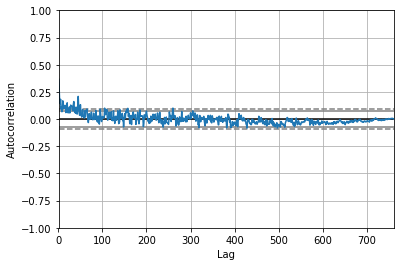

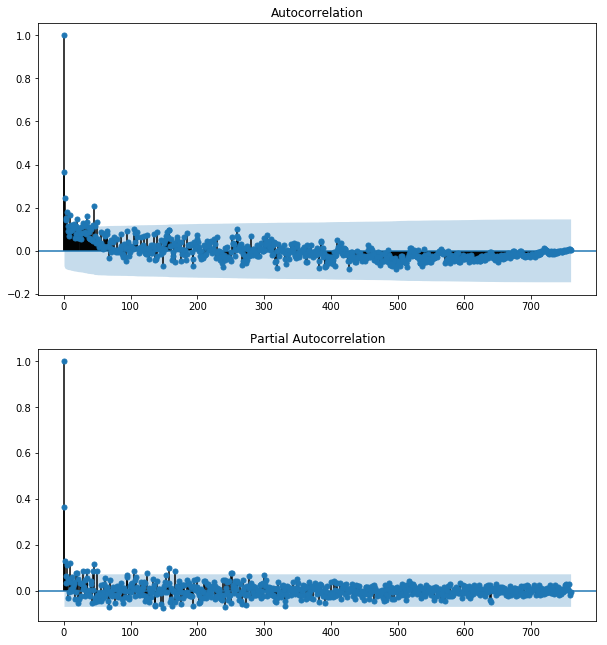

In [79]:
Arima_timeseries().corr_check(df_in_1261)
Arima_timeseries().acf_plot(df_in_1261)

lag 0: corr 1.0
lag 1: corr 0.23987868740970364
lag 10: corr 0.2200376345708469
lag 40: corr 0.2058096648669679
lag 20: corr 0.19179237402612245
lag 135: corr 0.17701599773559004
lag 16: corr 0.1553981521425922
lag 5: corr 0.15451217385240126
lag 129: corr 0.15182332309507088
lag 261: corr 0.15050710835340023
lag 30: corr 0.14933470612587268
lag 130: corr 0.1493127711593488
lag 26: corr 0.14687538674313344
lag 6: corr 0.1455605751589595
lag 15: corr 0.14547962071849832
lag 4: corr 0.14209806782997705
lag 256: corr 0.14201330438730722
lag 35: corr 0.13975935129345748
lag 361: corr 0.13820173795600443
lag 260: corr 0.13698523179195626
lag 24: corr 0.13693896926040636
lag 109: corr 0.13662619692608485
lag 200: corr 0.1347799461090837
lag 14: corr 0.13347180521456084
lag 235: corr 0.1323329700598163
lag 2: corr 0.13203920916769135
lag 230: corr 0.13158762327752954
lag 21: corr 0.13120466843983533
lag 19: corr 0.12872323687232082
lag 34: corr 0.12836209916700703
lag 216: corr 0.128075529590

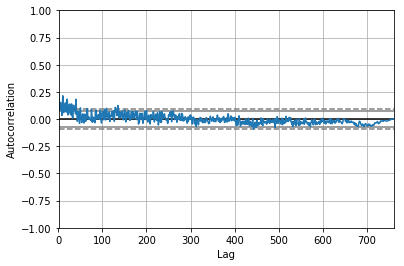

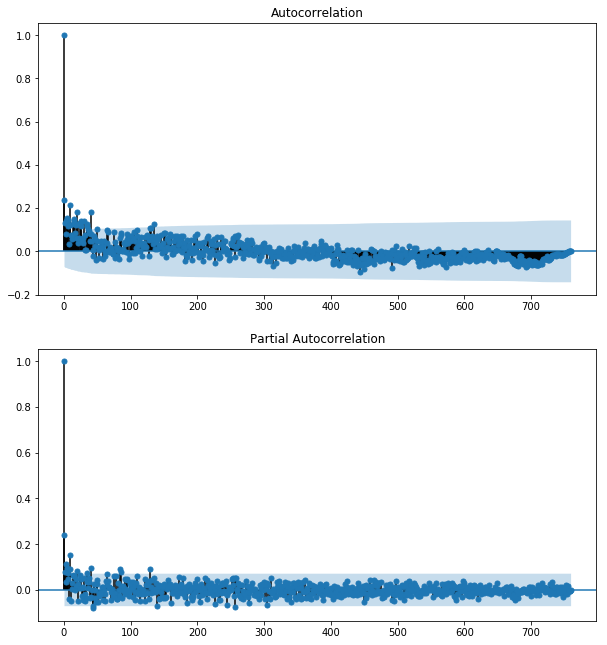

In [80]:
Arima_timeseries().corr_check(df_return_1261)
Arima_timeseries().acf_plot(df_return_1261)

In [81]:
df_return_diff1= df_return_1261.diff(1).iloc[1:]
df_in_diff1= df_in_1261.diff(1).iloc[1:]

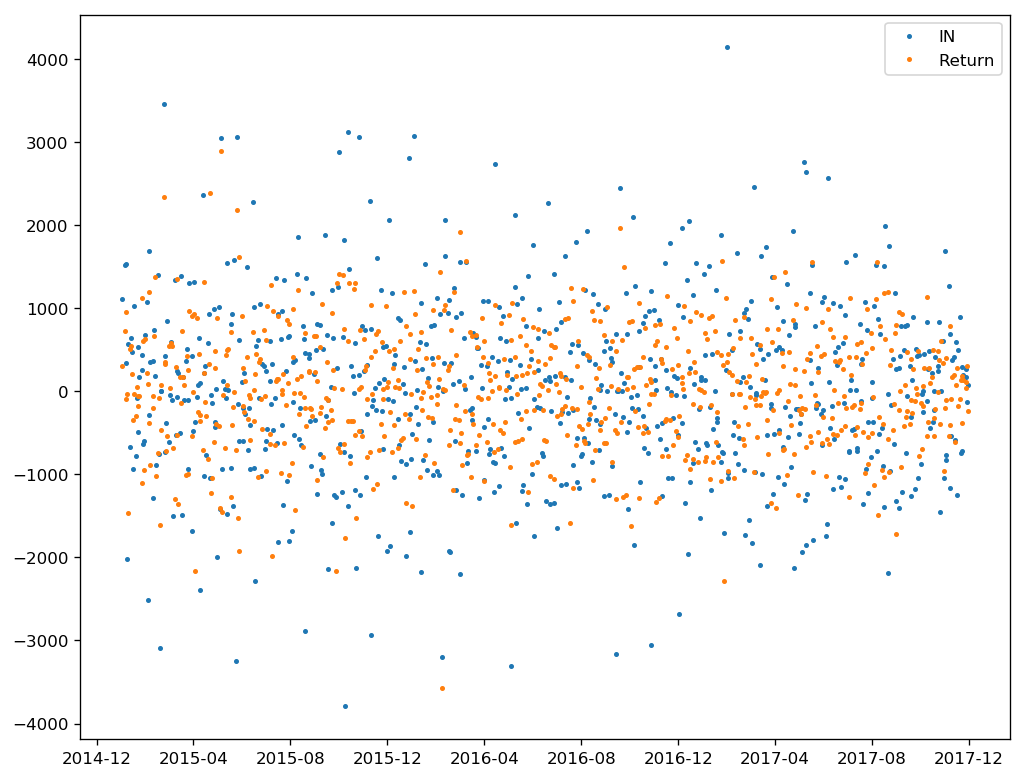

In [82]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_ds.iloc[1:], df_in_diff1, label= 'IN', ms= 2)
plt.plot_date(df_ds.iloc[1:], df_return_diff1, label= 'Return', ms= 2)
plt.legend()
plt.show()

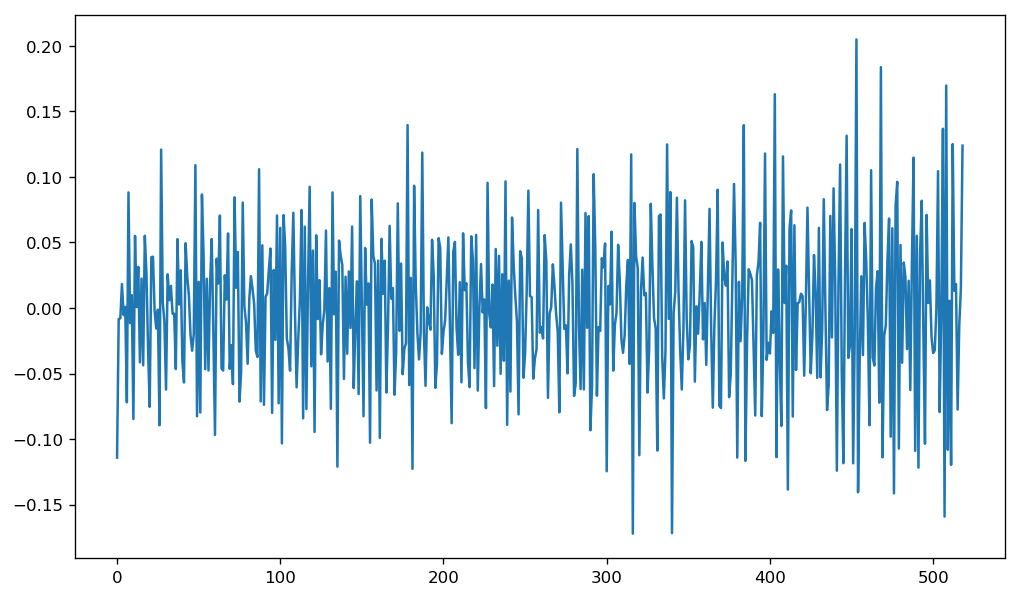

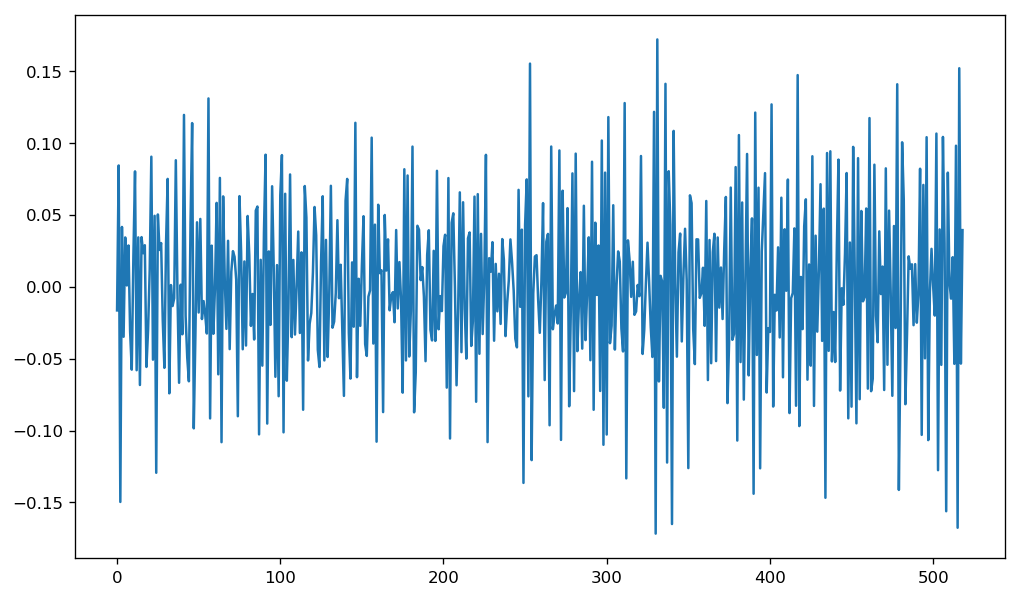

In [83]:
crosscorr= ccf(df_in_diff1, df_return_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()
crosscorr= ccf(df_return_diff1, df_in_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()

In [84]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
331,-0.171676
516,-0.167588
341,-0.165007
509,-0.156117
3,-0.149649
435,-0.146756
391,-0.143957
480,-0.141300
250,-0.136423
313,-0.133275
